# 深層ニューラルネットの訓練

In [1]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 勾配損失/爆発問題

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))

[-5, 5, -0.2, 1.2]

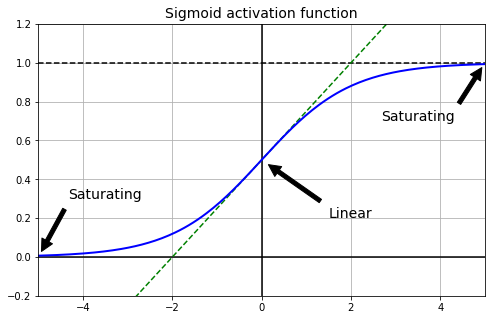

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(8, 5))

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

バックプロパゲーションは、出力層から入力層に向かって誤差勾配を伝える際、コスト関数を計算すると、勾配下降ステップに入ってから各パラメータを更新していく。
しかし、バックプロパゲーションが下の階層に進むに連れて勾配は緩やかになっていく。そのため、勾配下降による更新は、下の階層の接続の重みははとんど伝わらず、訓練はより良い解に収束しなくなる。これを`勾配損失`と呼ぶ。逆に勾配がどんどん急になり、層の重みの更新がとてつもなく大きくなり、アルゴリズムが発散してしまうことを`勾配爆発`と呼ぶ。

### Xavierの初期値とHeの初期値

In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [7]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name='hedden1')

W0830 17:55:33.400290 4464080320 deprecation.py:323] From <ipython-input-7-d061fe05414c>:2: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


`tf.layers.dense()`デフォルトではXavierの初期値を使用している。`tf.variance_scaling_initializer()`を使用すればHeの初期値を使用できるようになる。

### 非飽和活性化関数

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

[-5, 5, -0.5, 4.2]

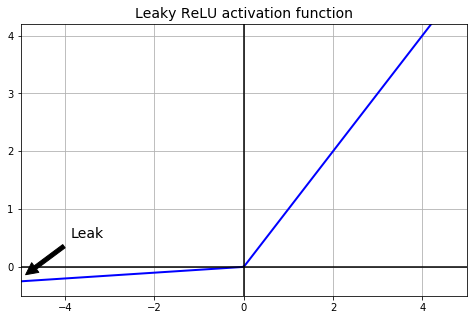

In [9]:
plt.figure(figsize=(8, 5))

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

In [10]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [11]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [12]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

W0830 17:55:40.836877 4464080320 deprecation.py:506] From /Users/shimizukousuke/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Leaky ReLUを使用してMNISTでニューラルネットワークをトレーニングする

In [13]:
reset_graph()

In [14]:
n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [15]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

In [16]:
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name='outputs')

In [17]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [18]:
learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

W0830 17:55:46.155700 4464080320 deprecation.py:323] From /Users/shimizukousuke/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [20]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [22]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [23]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./models/leaky_relu.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9494
10 Batch accuracy: 0.92 Validation accuracy: 0.9658
15 Batch accuracy: 0.94 Validation accuracy: 0.9708
20 Batch accuracy: 1.0 Validation accuracy: 0.976
25 Batch accuracy: 1.0 Validation accuracy: 0.9776
30 Batch accuracy: 0.98 Validation accuracy: 0.9778
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


In [24]:
with tf.Session() as sess:
    saver.restore(sess, './models/leaky_relu.ckpt')
    X_new_scaled = X_test[:50]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

W0830 17:56:53.965753 4464080320 deprecation.py:323] From /Users/shimizukousuke/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [25]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:50])

Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4]


### バッチ正規化

In [26]:
reset_graph()

In [27]:
n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [28]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name='outputs')
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

W0830 17:57:02.222970 4464080320 deprecation.py:323] From <ipython-input-28-067459e2b0bb>:6: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [29]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
training = tf.placeholder_with_default(False, shape=(), name='training')

In [30]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name='outputs')
logits = my_batch_norm_layer(logits_before_bn)

In [31]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope('dnn'):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name='hidden1')
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name='hidden2')
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name='outputs')
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [32]:
n_epochs = 20
batch_size = 200

In [33]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./models/batch_nomal.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


### 勾配クリッピング

In [34]:
reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

In [35]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='uy')

In [36]:
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    hidden3 = tf.layers.dense(hidden2, n_hidden2, activation=tf.nn.relu, name='hidden3')
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4')
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name='hidden5')
    logits = tf.layers.dense(hidden5, n_outputs, name='outputs')

In [37]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [38]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [39]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

In [40]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
n_epochs = 20
batch_size = 200

In [42]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

    save_path = saver.save(sess, "./models/clipping.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7942
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9216
6 Validation accuracy: 0.929
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9454
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9478
13 Validation accuracy: 0.953
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.959
18 Validation accuracy: 0.962
19 Validation accuracy: 0.9618


## プレトレーニング済みの層の再利用

### TensorFlowモデルの最利用

In [59]:
reset_graph()

In [60]:
saver = tf.train.import_meta_graph('./models/test.ckpt.meta')

In [61]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
dnn/hidden1/truncated_normal/shape
dnn/hidden1/truncated_normal/mean
dnn/hidden1/truncated_normal/stddev
dnn/hidden1/truncated_normal/TruncatedNormal
dnn/hidden1/truncated_normal/mul
dnn/hidden1/truncated_normal
dnn/hidden1/kernel
dnn/hidden1/kernel/Assign
dnn/hidden1/kernel/read
dnn/hidden1/zeros
dnn/hidden1/bias
dnn/hidden1/bias/Assign
dnn/hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/add
dnn/hidden1/Relu
dnn/hidden2/truncated_normal/shape
dnn/hidden2/truncated_normal/mean
dnn/hidden2/truncated_normal/stddev
dnn/hidden2/truncated_normal/TruncatedNormal
dnn/hidden2/truncated_normal/mul
dnn/hidden2/truncated_normal
dnn/hidden2/kernel
dnn/hidden2/kernel/Assign
dnn/hidden2/kernel/read
dnn/hidden2/zeros
dnn/hidden2/bias
dnn/hidden2/bias/Assign
dnn/hidden2/bias/read
dnn/hidden2/MatMul
dnn/hidden2/add
dnn/hidden2/Relu
dnn/outputs/truncated_normal/shape
dnn/outputs/truncated_normal/mean
dnn/outputs/truncated_normal/stddev
dnn/outputs/truncated_normal/TruncatedNormal
dnn/outputs/trunca

In [62]:
from tensorflow_graph_in_jupyter import show_graph

In [63]:
show_graph(tf.get_default_graph())